Now that we know which models are performing better, it's time to perform cross validation and tune hyperparameters.
- Do a google search for hyperparameter ranges for each type of model.

GridSearch/RandomSearch are a great methods for checking off both of these tasks.
- BUT we have a problem - if we calculated a numerical value to encode city (such as the mean of sale prices in that city) on the training data, we can't cross validate 
- The rows in each validation fold were part of the original calculation of the mean for that city - that means we're leaking information!
- While sklearn's built in functions are extremely useful, sometimes it is necessary to do things ourselves

You need to create two functions to replicate what Gridsearch does under the hood

**`custom_cross_validation()`**
- Should take the training data, and divide it into multiple train/validation splits. 
- Look into `sklearn.model_selection.KFold` to accomplish this - the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) shows how to split a dataframe and loop through the indexes of your split data. 
- Within your function, you should compute the city means on the training folds just like you did in Notebook 1 - you may have to re-join the city column to do this - and then join these values to the validation fold

**`hyperparameter_search()`**
- Should take the validation and training splits from your previous function, along with your dictionary of hyperparameter values
- For each set of hyperparameter values, fit your chosen model on each set of training folds, and take the average of your chosen scoring metric. [itertools.product()](https://docs.python.org/3/library/itertools.html) will be helpful for looping through all combinations of hyperparameter values
- Your function should output the hyperparameter values corresponding the highest average score across all folds. Alternatively, it could also output a model object fit on the full training dataset with these parameters.

Docstrings have been provided below to get you started. Once you're done developing your functions, you should move them to `functions_variables.py` to keep your notebook clean 

Bear in mind that these instructions are just one way to tackle this problem - the inputs and output formats don't need to be exactly as specified here.

In [33]:
import pandas as pd
from joblib import load
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.base import clone
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from itertools import product
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
# develop your custom functions here

def custom_cross_validation(X_transformed, y, model, n_splits =5):
    '''creates n_splits sets of training and validation folds

    Args:
      training_data: the dataframe of features and target to be divided into folds
      n_splits: the number of sets of folds to be created

    Returns:
      A tuple of lists, where the first index is a list of the training folds, 
      and the second the corresponding validation fold

    Example:
        >>> output = custom_cross_validation(train_df, n_splits = 10)
        >>> output[0][0] # The first training fold
        >>> output[1][0] # The first validation fold
        >>> output[0][1] # The second training fold
        >>> output[1][1] # The second validation fold... etc.
    '''

    return training_folds, validation_folds

def hyperparameter_search(training_folds, validation_folds, param_grid):
    '''outputs the best combination of hyperparameter settings in the param grid, 
    given the training and validation folds

    Args:
      training_folds: the list of training fold dataframes
      validation_folds: the list of validation fold dataframes
      param_grid: the dictionary of possible hyperparameter values for the chosen model

    Returns:
      A list of the best hyperparameter settings based on the chosen metric

    Example:
        >>> param_grid = {
          'max_depth': [None, 10, 20, 30],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4],
          'max_features': ['sqrt', 'log2']} # for random forest
        >>> hyperparameter_search(output[0], output[1], param_grid = param_grid) 
        # assuming 'ouput' is the output of custom_cross_validation()
        [20, 5, 2, 'log2'] # hyperparams in order
    '''

    return hyperparameters


##  Loading my Preprocessed Data and my cleaned table

In [19]:
df= pd.read_csv('/Users/asalzooashkiany/Documents/-DS-Midterm-Project./data/my_dataframe.csv')

In [2]:
# Load the files
directory_path ='/Users/asalzooashkiany/Documents/-DS-Midterm-Project./notebooks'

X_train_transformed = load(directory_path + 'X_train_transformed.joblib')
X_test_transformed = load(directory_path + 'X_test_transformed.joblib')
y_train = load(directory_path + 'y_train.joblib')
y_test = load(directory_path + 'y_test.joblib')

preprocessor = load(directory_path + 'preprocessor.joblib')

In [3]:
type(y_train)

pandas.core.series.Series

In [4]:
type(X_test_transformed)

numpy.ndarray

In [5]:
X_train_transformed.shape

(3709, 22)

In [6]:
y_train_array = y_train.to_numpy()


In [7]:
y_train_array = y_train.values


In [8]:
y_train.shape

(3709,)

### Residuals Plot: the difference between the observed and predicted values)

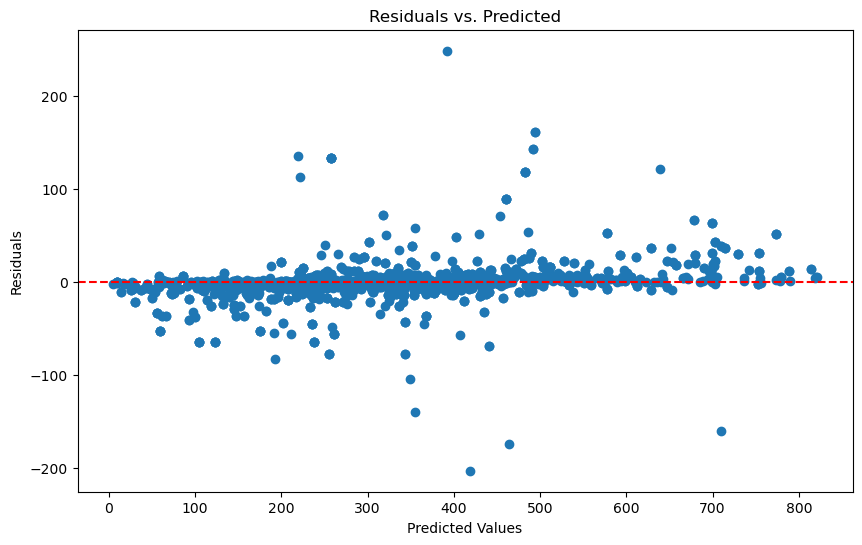

In [18]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predictions
y_pred = best_model.predict(X_test_transformed)

# Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

### doing cross validation to see how making the train data into 5 sets and applying our model will effect the data

In [9]:

def custom_cross_validation(X_transformed, y, model, n_splits=5):
    kf = KFold(n_splits=n_splits)
    mae_scores, r2_scores = [], []

    # Convert y to a numpy array to ensure alignment with numpy indexing
    y_array = y.to_numpy() if hasattr(y, 'to_numpy') else y

    for train_index, val_index in kf.split(X_transformed):
        # Split the pre-transformed data
        X_train_fold, X_val_fold = X_transformed[train_index], X_transformed[val_index]
        y_train_fold, y_val_fold = y_array[train_index], y_array[val_index]

        # Clone the model to ensure a fresh model for each fold
        model_clone = clone(model)

        # Fit and evaluate the model
        model_clone.fit(X_train_fold, y_train_fold)
        y_pred = model_clone.predict(X_val_fold)

        mae_scores.append(mean_absolute_error(y_val_fold, y_pred))
        r2_scores.append(r2_score(y_val_fold, y_pred))

    # Calculate average scores
    avg_mae = np.mean(mae_scores)
    avg_r2 = np.mean(r2_scores)

    return {'MAE': avg_mae, 'R2': avg_r2}


### choosing both RandomForestRegressor and XGBRegressor since they both did well on my model selection file

In [10]:


# Assuming the custom_cross_validation function is already defined as before

random_forest_model = RandomForestRegressor(random_state=34)
xgboost_model = XGBRegressor(objective='reg:squarederror', random_state=34)

y_train_reset = y_train.reset_index(drop=True)

# Evaluate Random Forest
rf_evaluation_results = custom_cross_validation(X_train_transformed, y_train, random_forest_model, n_splits=5)
print("Random Forest - Average Cross-Validation Scores:")
print(f"MAE: {rf_evaluation_results['MAE']}")
print(f"R²: {rf_evaluation_results['R2']}")


# Evaluate XGBoost
xgb_evaluation_results = custom_cross_validation(X_train_transformed, y_train, xgboost_model, n_splits=5)
print("\nXGBoost - Average Cross-Validation Scores:")
print(f"MAE: {xgb_evaluation_results['MAE']}")
print(f"R²: {xgb_evaluation_results['R2']}")



Random Forest - Average Cross-Validation Scores:
MAE: 19.856230481522573
R²: 0.9465826232583723

XGBoost - Average Cross-Validation Scores:
MAE: 20.599059402157504
R²: 0.9475574743443825


## hyperparameter tuning:
### is the process of finding the best parameters for a model to optimize its performance. In the case of the `RandomForestRegressor`, these parameters could include the number of trees in the forest, the maximum depth of each tree, and others.

In [12]:

def hyperparameter_search(X_transformed, y, model, param_grid, n_splits=5):
    # Converting y to a numpy array 
    y_array = y.to_numpy() if hasattr(y, 'to_numpy') else y

    # Prepare KFold cross-validation
    kf = KFold(n_splits=n_splits)

    # Store the best hyperparameters and their corresponding score
    best_score = float('inf')
    best_params = None

    # Iterate over all combinations of hyperparameters
    for params in product(*param_grid.values()):
        current_params = dict(zip(param_grid.keys(), params))
        model.set_params(**current_params)

        scores = []

        for train_index, val_index in kf.split(X_transformed):
            X_train_fold, X_val_fold = X_transformed[train_index], X_transformed[val_index]
            y_train_fold, y_val_fold = y_array[train_index], y_array[val_index]

            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            score = mean_absolute_error(y_val_fold, y_pred)
            scores.append(score)

        avg_score = np.mean(scores)

        if avg_score < best_score:
            best_score = avg_score
            best_params = current_params

    # Optionally, fit the model on the entire dataset with the best hyperparameters
    model.set_params(**best_params)
    model.fit(X_transformed, y_array)

    return best_params, best_score, model


In [13]:
from sklearn.ensemble import RandomForestRegressor

# Define the model
model = RandomForestRegressor(random_state=34)

# Define the hyperparameter grid to search over
# n_estimators parameter specifies the number of trees in the forest of the model.
param_grid = {
    'n_estimators': [60,70,80,90,100],
    'max_depth': [None,1, 2, 3],
    'min_samples_split': [2, 5]
}

# Assuming X_train_transformed and y_train are already defined
best_params, best_score, best_model = hyperparameter_search(X_train_transformed, y_train, model, param_grid, n_splits=5)

print("Best Hyperparameters:", best_params)
print("Best Score (MAE):", best_score)


Best Hyperparameters: {'n_estimators': 90, 'max_depth': None, 'min_samples_split': 2}
Best Score (MAE): 19.801776807248995


In [39]:
model = RandomForestRegressor(random_state=34)

# Define the parameter grid
param_grid = {
    'n_estimators': [80,90,100, 200],  # Number of trees in the forest
    'max_depth': [None,1,2,3, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5]  # Minimum number of samples required to split an internal node
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),  # Use MAE for scoring, and we want to minimize it
    cv=5,  # Number of folds in cross-validation
    verbose=1,
    n_jobs=-1  # Use all processors in parallel
)

# Fit the GridSearchCV to the training data
grid_result = grid_search.fit(X_train_transformed, y_train)

# Retrieve the best parameters and the best score
best_params = grid_result.best_params_
best_score = grid_result.best_score_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Score (MAE): {best_score}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 90}
Best Score (MAE): -19.801776807248995


## Hyperparameter Tuning and Cross-Validation

## Here's what each part of the blew code does:

##### 1. **FeatureUnion**: This is a scikit-learn method that combines features generated by different transformers. In this case, `PCA` (Principal Component Analysis) reduces the dimensionality of the data, while `SelectKBest` selects the top K features based on a univariate statistical test.

#####  2. **Pipeline**: Pipelines help to assemble several steps that can be cross-validated together while setting different parameters. In this pipeline, we have three steps: scaling with `StandardScaler`, feature extraction with `FeatureUnion`, and regression with `RandomForestRegressor`.

#### 3. **Param_grid**: This dictionary contains the hyperparameters we want to tune for the models within the pipeline. For example, `n_components` for PCA, `k` for `SelectKBest`, and `n_estimators` and `max_depth` for the `RandomForestRegressor`.

##### 4. **GridSearchCV**: This function performs an exhaustive search over the specified parameter values for an estimator, in this case, the pipeline. The parameter `cv=5` specifies that we are using 5-fold cross-validation, which means the training data is split into five smaller sets; the model is trained on four of these and validated on the fifth.

##### 5. **Best Hyperparameters and Score**: After the grid search is complete, we extract the best hyperparameters found and the corresponding score. The score is the mean cross-validated score of the best estimator, giving us an indication of how well the model performs.


In [14]:
feature_union = FeatureUnion([
    ('pca', PCA()),  # Principal Component Analysis
    ('select_best', SelectKBest())  # Selecting the best features
])

pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),  # Feature scaling
    ('features', feature_union),  # Feature extraction
    ('regressor', RandomForestRegressor(random_state=34))  # Regressor
])

# Define the grid of hyperparameters to search
param_grid = {
    'features__pca__n_components': [3, 5],
    'features__select_best__k': [1, 3, 6],
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

# Perform grid search on the training data
grid_search.fit(X_train_transformed, y_train)

# Get the best hyperparameters and the corresponding score
best_hyperparams = grid_search.best_params_
best_score = grid_search.best_score_  # Note: This is the mean cross-validated score of the best estimator

# Print the outcome
print(f'Best hyperparameters for training set: {best_hyperparams}')
print(f'Best cross-validation score on training set: {best_score}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best hyperparameters for training set: {'features__pca__n_components': 5, 'features__select_best__k': 6, 'regressor__max_depth': 20, 'regressor__n_estimators': 100}
Best cross-validation score on training set: 0.9408633355628258


### blew we did tuning hyperparameters using the training data (X_train_transformed, y_train), which then it evaluates the performance on the test data (X_test_transformed, y_test).

In [15]:
feature_union = FeatureUnion([('pca', PCA()), 
                              ('select_best', SelectKBest())]) 

pipeline = Pipeline(steps=[('scaling', StandardScaler()),
                           ('features', feature_union),
                           ('regressor', RandomForestRegressor(random_state=34))])

# Find the best hyperparameters using GridSearchCV on the train set
param_grid = {
    'features__pca__n_components': [3, 5],  # Number of components for PCA
    'features__select_best__k': [1, 3, 6],  # Number of top features to select
    'regressor__n_estimators': [100, 200],  # Number of trees for RandomForest
    'regressor__max_depth': [None, 10, 20]  # Maximum depth of the trees
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

# Fit the GridSearchCV to find the best model
grid.fit(X_train_transformed, y_train)

# Extracting the best model, hyperparameters, and score
best_model = grid.best_estimator_
best_hyperparams = grid.best_params_
best_r2 = grid.score(X_test_transformed, y_test)  

print(f'Best test set R^2: {best_r2}\nAchieved with hyperparameters: {best_hyperparams}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best test set R^2: 0.9810546635811834
Achieved with hyperparameters: {'features__pca__n_components': 5, 'features__select_best__k': 3, 'regressor__max_depth': 20, 'regressor__n_estimators': 100}


## the outcome:
#### 1_Good Generalization: The model is performing well on both the training and the unseen test data, indicating good generalization.
#### 2_Consistent Hyperparameters: The hyperparameters are consistent between training and testing, which means the model tuning is reliable.
#### 3_High R-squared Value: The high R-squared value (close to 1) for the test set indicates that the model predictions are very close to the actual values, explaining a large portion of the variance.
#### 4_Feature Selection Impact: There's a slight difference in the number of top features selected (k: 6 for training vs. 3 for testing), which suggests that while the model performs well in both cases, the exact features that are most informative can vary depending on the data split. This could be worth further investigation.


In [49]:
from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('scaling', StandardScaler()),
                ('features',
                 FeatureUnion(transformer_list=[('pca', PCA()),
                                                ('select_best',
                                                 SelectKBest())])),
                ('regressor', RandomForestRegressor(random_state=34))])

###  Prediction Error Plot: A plot to compare the actual vs. predicted values.

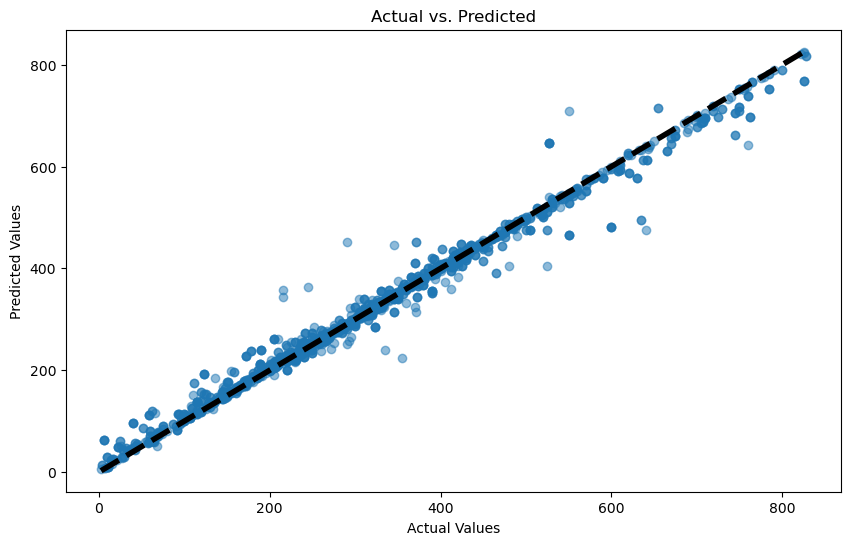

In [55]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.title("Actual vs. Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()


## PCA Component Analysis: 
### seeing that the variance explained by the components increases sharply with the first few components and then levels off.

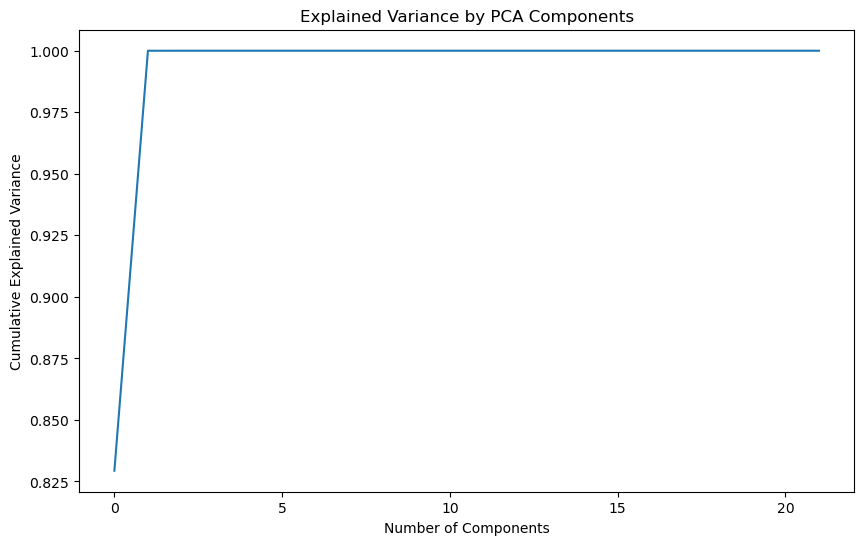

In [56]:
pca = PCA().fit(X_train_transformed)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()


# now i will use the whole data to tain the model

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# Defining the columns we want to apply OHE to
categorical_features = ['list_season', 'sold_season', 'Region','Type']

# Creating the column transformer using OneHotEncoder for the categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' ) # Pass through other columns unchanged

In [26]:
feature_union = FeatureUnion([
    ('pca', PCA(n_components=5)),
    ('select_best', SelectKBest(k=6))
])
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaling', StandardScaler()),
    ('features', feature_union),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        random_state=34
    ))
])

X = df.drop(columns='Sold Price')
y = df['Sold Price']

# Train the model on the full dataset
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['list_season', 'sold_season',
                                                   'Region', 'Type'])])),
                ('scaling', StandardScaler()),
                ('features',
                 FeatureUnion(transformer_list=[('pca', PCA(n_components=5)),
                                                ('select_best',
                                                 SelectKBest(k=6))])),
                ('regressor',
                 RandomForestRegressor(max_depth=20, random_state=34))])

## Saving the Model

In [32]:
directory_path = '/Users/asalzooashkiany/Documents/-DS-Midterm-Project/notebooks/models'

# Check if the directory exists, and if not, create it
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Full path for the pipeline file
file_path = os.path.join(directory_path, 'pipeline.pickle')

# Save the pipeline
with open(file_path, 'wb') as f:
    pickle.dump(pipeline, f)



We want to make sure that we save our models.  In the old days, one just simply pickled (serialized) the model.  Now, however, certain model types have their own save format.  If the model is from sklearn, it can be pickled, if it's xgboost, for example, the newest format to save it in is JSON, but it can also be pickled.  It's a good idea to stay with the most current methods. 
- you may want to create a new `models/` subdirectory in your repo to stay organized

In [ ]:
# save your best model here

Once you've identified which model works the best, implement a prediction pipeline to make sure that you haven't leaked any data, and that the model could be easily deployed if desired.
- Your pipeline should load the data, process it, load your saved tuned model, and output a set of predictions
- Assume that the new data is in the same JSON format as your original data - you can use your original data to check that the pipeline works correctly
- Beware that a pipeline can only handle functions with fit and transform methods.
- Classes can be used to get around this, but now sklearn has a wrapper for user defined functions.
- You can develop your functions or classes in the notebook here, but once they are working, you should import them from `functions_variables.py` 

In [ ]:
# Build pipeline here

Pipelines come from sklearn.  When a pipeline is pickled, all of the information in the pipeline is stored with it.  For example, if we were deploying a model, and we had fit a scaler on the training data, we would want the same, already fitted scaling object to transform the new data with.  This is all stored when the pipeline is pickled.
- save your final pipeline in your `models/` folder

In [ ]:
# save your pipeline here